In [567]:
import csv
import gzip
import logomaker
import numpy as np
import pandas as pd
import torch
from captum.attr import DeepLift, Saliency
from captum.attr import visualization as viz
from torch.utils.data import DataLoader

# add smoothGrad/noiseTunnel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Data

In [568]:
# from refactor import ConvNet
# from refactor.dataset import chipseq_dataset
from model import ConvNet
from data import chipseq_dataset

# index 284 has example of GATAA and ATC (looking for TTATC)
# seed 2 highlights GATAA
# seed 3 highlights ATC and GATAA

# index 285 has example of GATAA 
# index 286 has example of TTATC 
# index 287 has example of GATAA 
# index 288 has example of TTATC seed 4 highlights a second ATC for ShiftSmooth that is missed without the method

seed = 6
set_index = 284

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

def seqtopad(sequence, motiflen, kind="DNA"):
    rows = len(sequence) + 2 * motiflen - 2
    S = np.zeros([rows, 4], dtype=np.float32)
    base = "ACGT" if kind == "DNA" else "ACGU"
    for i in range(rows):
        if i < motiflen - 1 or i >= len(sequence) + motiflen - 1:
            S[i] = 0.25
        elif sequence[i - motiflen + 1] in base:
            S[i, base.index(sequence[i - motiflen + 1])] = 1
    return S.T


class Chip_test:
    def __init__(self, filename, motiflen=24):
        self.file = filename
        self.motiflen = motiflen

    def openFile(self):
        test_dataset = []
        with gzip.open(self.file, "rt") as data:
            next(data)
            reader = csv.reader(data, delimiter="\t")
            for row in reader:
                test_dataset.append([seqtopad(row[2], self.motiflen), [int(row[3])]])
        return test_dataset

data_path = "data/encode"
chipseq_test = Chip_test(
    f"{data_path}/GATA1_K562_GATA-1_USC_B.seq.gz"
)
test_data = chipseq_test.openFile()
test_dataset = chipseq_dataset(test_data)
batchSize = test_dataset.__len__()
print(batchSize)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)

1000


## Load Trained Model

In [569]:
# from main import load_model

save_path = "/home/nielseni6/PythonScripts/TFBS/weights/moe"
params = [torch.load(f"{save_path}/best_hyperparameters_{i}.pth") for i in range(3)]
# best_hyperparameters = torch.load(f"{save_path}/best_hyperparameters_{0}.pth")
print("best_hyperparameters: ", params)

configs = []
for best_hyperparameters in params:
    config = {
        "nummotif": 16,
        "motiflen": 24,
        "poolType": best_hyperparameters["poolType"],
        "sigmaConv": best_hyperparameters["sigmaConv"],
        "dropprob": best_hyperparameters["dropprob"],
        "learning_rate": best_hyperparameters["learning_rate"],
        "momentum_rate": best_hyperparameters["momentum_rate"],
        "num_features": 32,
        "d_model": 32,
        "num_heads": best_hyperparameters["num_heads"],
        "dim_feedforward": best_hyperparameters["dim_feedforward"],
        "encoder_dropout": best_hyperparameters["encoder_dropout"],
        "num_layers": best_hyperparameters["num_layers"],
    }
    configs.append(config)

individual_models = [ConvNet(configs[i]).to(device) for i in range(len(configs))]

motifs = ["ARID3A", "FOXM1", "GATA3"]
model_paths = [f"{save_path}/best_model_{motifs[i]}.pth" for i in range(len(motifs))]
checkpoints = [torch.load(model_paths[i]) for i in range(len(model_paths))]

nets = [individual_models[i] for i in range(len(individual_models))]
for i, net in enumerate(nets):
    net.load_state_dict(checkpoints[i])



best_hyperparameters:  [{'poolType': 'max', 'neuType': 'nohidden', 'dropprob': 0.75, 'sigmaConv': 9.190936504955238e-06, 'sigmaNeu': 0.0003203581261519976, 'learning_rate': 0.008117807597734948, 'momentum_rate': 0.9737496847138191, 'dim_feedforward': 128, 'num_heads': 2, 'encoder_dropout': 0.1718530815639031, 'num_layers': 2}, {'poolType': 'max', 'neuType': 'hidden', 'dropprob': 0.75, 'sigmaConv': 1.5959750970983724e-07, 'sigmaNeu': 1.068212406067445e-05, 'learning_rate': 0.006076001199937494, 'momentum_rate': 0.951162656299491, 'dim_feedforward': 32, 'num_heads': 16, 'encoder_dropout': 0.4682069640448002, 'num_layers': 3}, {'poolType': 'maxavg', 'neuType': 'hidden', 'dropprob': 0.5, 'sigmaConv': 6.207567189230288e-07, 'sigmaNeu': 6.192035613278874e-05, 'learning_rate': 0.006358015744028443, 'momentum_rate': 0.9558591223669254, 'dim_feedforward': 96, 'num_heads': 1, 'encoder_dropout': 0.1991325514637879, 'num_layers': 3}]


In [570]:
import torch.nn as nn
import torch.nn.functional as F

def shift_list(my_list, num):
    num = abs(num)
    my_list_ = my_list.copy()

    for i in range(num):
        if num > 0:
            my_list[:num] = my_list_[-num:]
            my_list[num:] = my_list_[:-num]
            # my_list.append(my_list.pop(0))
        elif num < 0:
            my_list[num:] = my_list_[:-num]
            my_list[:num] = my_list_[-num:]
            # my_list.insert(0, my_list.pop())
        else:
            my_list[:] = my_list_
    return my_list

def shift(arr, num):
    # result = np.empty_like(arr)
    result = torch.zeros_like(arr)
    if num > 0:
        result[:num] = arr[-num:]
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = arr[:-num]
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts, embedding_size=32):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        self.embedding_size = embedding_size
        self.gate = nn.Linear(num_experts * embedding_size, num_experts)
        self.classifier = nn.Linear(embedding_size, 1)
        self.experts = nn.ModuleList(
            [nn.Linear(embedding_size, 32) for _ in range(num_experts)]
        )
    
    def forward(self, embeddings, return_gates=False):
        gating_weights = F.softmax(self.gate(embeddings), dim=1)
        embeddings = embeddings.view(-1, self.num_experts, self.embedding_size)
        gating_weights = gating_weights.unsqueeze(-1)
        combined_embedding = torch.mean(gating_weights * embeddings, dim=1)
        return (self.classifier(combined_embedding), gating_weights) if return_gates else self.classifier(combined_embedding)

moe_model = MixtureOfExperts(num_experts=len(nets), embedding_size=32).to(device)
checkpoint = torch.load(f"{save_path}/moe_model.pth")
moe_model.load_state_dict(checkpoint)
# nets.append(moe_model)

# Pick net to use for attribution (e.g. nets[0] for ARID3A, nets[1] for FOXM1, nets[2] for GATA3)
net = nets[2]

def run_moe(data, moe_model, nets, return_gates=False):
    total_preds, total_targets = [], []
    separate_data = True if type(data) == list else False
    if separate_data:
        embeddings = [model(data[i], return_embedding=True) for i, model in enumerate(nets)]
    else:
        embeddings = [model(data, return_embedding=True) for model in nets]
    concatenated = torch.cat(embeddings, dim=1)
    output = moe_model(concatenated, return_gates=return_gates)
    if return_gates:
        output, gating_weights = output
    pred_sig = torch.sigmoid(output)
    total_preds.extend(pred_sig.clone().detach().cpu().numpy())
    # total_targets.extend(target.clone().detach().cpu().numpy())

    return (output, gating_weights) if return_gates else output







## Generate Attribution Maps

In [571]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input, **kwargs)
    return tensor_attributions

original_image = np.transpose((data.cpu().detach().numpy()), (0, 1, 2))

saliency = Saliency(net)
grads = saliency.attribute(data)
grads = grads.squeeze().detach().cpu().numpy()

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, data, baselines=data * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (0, 1, 2))

print(grads.shape, attr_dl.shape, original_image.shape)

index = np.random.randint(0, grads.shape[0])
while target[index][0] == 0:
    index = np.random.randint(0, grads.shape[0])
# Good index that includes ATC and GATAA is index = 284
index = set_index

print(index)
grads = grads[index]
original_image = original_image[index]
attr_dl = attr_dl[index]

print("original_image.shape: ", original_image.shape)
mask = original_image[0] != 0.25
print("mask.shape: ", mask.shape)
original_image = original_image[:,mask]
grads = grads[:,mask]
attr_dl = attr_dl[:,mask]
print("original_image.shape: ", original_image.shape)
shape = original_image.shape

print(grads.shape, attr_dl.shape, original_image.shape)
grads = grads.reshape(shape[0], shape[1], 1)
attr_dl = attr_dl.reshape(shape[0], shape[1], 1)
original_image = original_image.reshape(shape[0], shape[1], 1)
print(grads.shape, attr_dl.shape, original_image.shape)

(1000, 4, 147) (1000, 4, 147) (1000, 4, 147)
284
original_image.shape:  (4, 147)
mask.shape:  (147,)
original_image.shape:  (4, 101)
(4, 101) (4, 101) (4, 101)
(4, 101, 1) (4, 101, 1) (4, 101, 1)


/home/nielseni6/envs/tfbs/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/nielseni6/envs/tfbs/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


## ShiftSmooth

In [572]:
def returnGradPred(img, net=net, magnitude=False, max_only=False):
    
    img.requires_grad_(True)
    pred = net(img)
    # label = torch.tensor([int(torch.max(pred[0], 0)[1])])
    # if (torch.cuda.is_available()):
    #     label = label.cuda()

    Sc_dx = torch.autograd.grad(pred, img, 
                                create_graph=True, retain_graph=True,
                                )[0]
    
    # loss = F.binary_cross_entropy_with_logits(pred, label.unsqueeze(0).float())#criterion(pred, label)
    # loss.backward()
    # Sc_dx = img.grad

    grad = (torch.tensor(Sc_dx.clone().detach().cpu().numpy()))

    if max_only:
        max_grads = torch.max(grad, dim=1)[0]
        mask = (grad == max_grads)
        Sc_dx[~mask] = 0

    if magnitude:
        Sc_dx = abs(Sc_dx)

    return Sc_dx, pred

def returnGradPredMoE(img, moe_model, nets, magnitude=False, max_only=False, gate_scaling=False):
    
    separate_data = True if type(img) == list else False

    if separate_data:
        for i in range(len(img)):
            img[i] = img[i].requires_grad_(True)
    else:
        img.requires_grad_(True)
    
    pred = run_moe(img, moe_model, nets, return_gates=gate_scaling)
    if gate_scaling:
        pred, gating_weights = pred
        print("pred: ", pred, "gating_weights.shape: ", gating_weights.shape)
    n_outputs = len(img) if separate_data else 1
    Sc_dxs = []
    for i in range(n_outputs):
        im = img[i] if separate_data else img
        Sc_dx = torch.autograd.grad(pred, im, 
                                    create_graph=True, retain_graph=True,
                                    )[0]
        
        grad = (torch.tensor(Sc_dx.clone().detach().cpu().numpy()))

        if max_only:
            max_grads = torch.max(grad, dim=1)[0]
            mask = (grad == max_grads)
            Sc_dx[~mask] = 0

        if magnitude:
            Sc_dx = abs(Sc_dx)

        if separate_data:
            Sc_dxs.append(Sc_dx)
        else:
            Sc_dxs = Sc_dx
    if gate_scaling:
        # print("gating_weights.shape: ", gating_weights.shape, "torch.stack(Sc_dxs).shape:", torch.stack(Sc_dxs).shape)
        Sc_dxs = [gating_weights[0][i][0] * sc for i, sc in enumerate(Sc_dxs)]
    
    return Sc_dxs, pred

def GetAttShiftSmooth(
  x_value, nshiftlr=1,
  magnitude=False, max_only=False, net = net, moe_model=None):
    
    softmax = torch.nn.Softmax(dim=1) if max_only else None
    x_np = torch.tensor(x_value)
    
    k = 0
    total_gradients = torch.tensor(torch.zeros_like(x_value)).to(device)
    
    for i in range(nshiftlr*2 + 1):

        x_shifted = torch.roll(torch.tensor(x_np.clone().detach().cpu().numpy()), i - nshiftlr, dims=2)

        if moe_model is not None:
            gradient, pred = returnGradPredMoE(x_shifted.clone().detach().to(device), moe_model, nets=net) 
        else: 
            gradient, pred = returnGradPred(x_shifted.clone().detach().to(device), net=net)

        grad = torch.roll(torch.tensor(gradient.clone().detach().cpu().numpy()).to(device), (nshiftlr - i), dims=2)

        total_gradients += grad.clone().detach()
        k += 1
    
    grads = total_gradients.clone().detach() 
    if max_only:
        # grads = softmax(grads) * grads
        max_grads = torch.max(grads, dim=1)[0]
        mask = (grads == max_grads)
        total_gradients[~mask] = 0
        

    if magnitude:
        total_gradients += abs(total_gradients)
    sq = 2 if magnitude else 1

    return ((total_gradients) / (k))#(nshiftlr*2 + 1))# ** sq

# shp = data[index].unsqueeze(0).shape
# dat = data[index].unsqueeze(0).clone().detach().cpu().numpy()
dat = torch.tensor(np.transpose(original_image, (2, 0, 1)), dtype = torch.float32).to(device)
shp = dat.shape

########## Choose Model (Not MoE) ##########
# Pick net to use for attribution (e.g. nets[0] for ARID3A, nets[1] for FOXM1, nets[2] for GATA3)
net = nets[2]
model = net # this will be cleaned up

########## SET PARAMETERS FOR ATTRIBUTIONS ##########
# only show the most important nucleotide
max_only = False 
# absolute value of attribution
magnitude = False 
# only show letters corresponding to actual sequence (will be true for paper results)
original_sequence_only = False 
#####################################################

sequence = original_image if original_sequence_only else 1

#################### SINGLE MODEL ####################
grads = returnGradPred(torch.tensor(dat, dtype = torch.float32).to(device), 
                       magnitude=magnitude, max_only=max_only, net = model
                       )[0].reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence
attr_shiftsmooth = GetAttShiftSmooth(dat, nshiftlr=1, magnitude=magnitude, max_only=max_only, net = model
                                     ).reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence
attr_shiftsmooths = [(GetAttShiftSmooth(dat, nshiftlr=i, magnitude=magnitude, max_only=max_only, net = model)
                     .reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence, i) 
                     for i in range(2, 100, 75)]
######################################################

#################### MoE Model (individual experts attribution) ####################
datas = [dat.clone().detach() for _ in range(len(nets))]
output = run_moe(datas, moe_model, nets)
moe_grad = returnGradPredMoE(datas, magnitude=magnitude, max_only=max_only, 
                          moe_model=moe_model, nets=nets, gate_scaling=False
                          )[0]
moe_grads_separate = [(gd.reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence) for gd in moe_grad]
####################################################################################
##################### MoE Model total forward pass attribution #####################
moe_grad = returnGradPredMoE(dat, magnitude=magnitude, max_only=max_only, 
                          moe_model=moe_model, nets=nets
                          )[0].reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence

moe_shiftsmooths = [(GetAttShiftSmooth(dat, nshiftlr=i, magnitude=magnitude, max_only=max_only, 
                     net = nets, moe_model=moe_model)
                     .reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence, i) 
                     for i in range(2, 100, 75)]
####################################################################################
# x_np = data[index].unsqueeze(0).clone().detach().cpu().numpy()
# x_np = torch.tensor(x_np, dtype = torch.float32).cuda()
# vanilla_grads = abs(returnGradPred(x_np)[0].reshape(shp[1], shp[2], shp[0]) ** 2).clone().detach().cpu().numpy()


/tmp/ipykernel_3050148/3906832473.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grads = returnGradPred(torch.tensor(dat, dtype = torch.float32).to(device),
/tmp/ipykernel_3050148/3906832473.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_np = torch.tensor(x_value)
/tmp/ipykernel_3050148/3906832473.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_gradients = torch.tensor(torch.zeros_like(x_value)).to(device)


## Plot

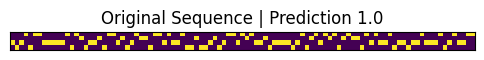

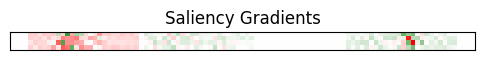

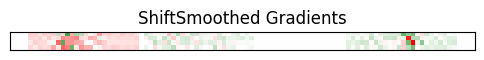

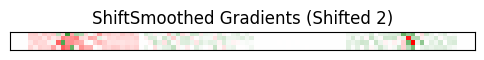

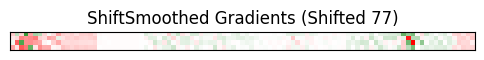

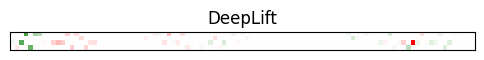

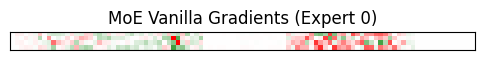

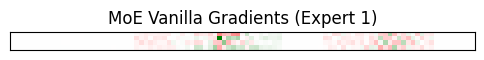

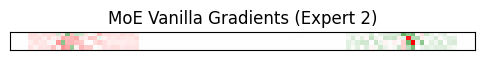

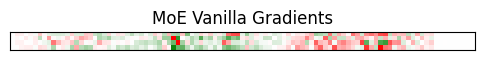

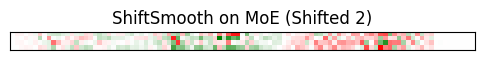

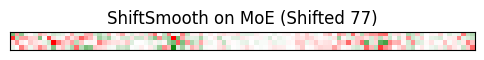

In [573]:
_ = viz.visualize_image_attr(
    None,
    original_image,
    method="original_image",
    title="Original Sequence | Prediction {}".format(target[index][0]),
)
################################### SINGLE MODEL ###################################
_ = viz.visualize_image_attr(
    grads, original_image, method="heat_map", sign="all", title="Saliency Gradients"
)

# _ = viz.visualize_image_attr(
#     vanilla_grads, original_image, method="heat_map", sign="all", title="Vanilla Gradients"
# )

_ = viz.visualize_image_attr(
    attr_shiftsmooth, original_image, method="heat_map", sign="all", title="ShiftSmoothed Gradients"
)

for attr_shiftsmooth2, i in attr_shiftsmooths:
    _ = viz.visualize_image_attr(
        attr_shiftsmooth2, original_image, method="heat_map", sign="all", title=f"ShiftSmoothed Gradients (Shifted {i})"
    )
# _ = viz.visualize_image_attr(
#     attr_shiftsmooth2, original_image, method="heat_map", sign="all", title="ShiftSmoothed Gradients (Shifted 2)"
# )
####################################################################################

#################### MoE Model (individual experts attribution) ####################

for i, moe_grad_ in enumerate(moe_grads_separate):
    _ = viz.visualize_image_attr(
        moe_grad_, original_image, method="heat_map", sign="all", title=f"MoE Vanilla Gradients (Expert {i})"
    )
####################################################################################
##################### MoE Model total forward pass attribution #####################
_ = viz.visualize_image_attr(
    moe_grad, original_image, method="heat_map", sign="all", title="MoE Vanilla Gradients"
)

for moe_shiftsmooth, i in moe_shiftsmooths:
    _ = viz.visualize_image_attr(
        moe_shiftsmooth, original_image, method="heat_map", sign="all", title=f"ShiftSmooth on MoE (Shifted {i})"
    )
####################################################################################

_ = viz.visualize_image_attr(
    attr_dl, original_image, method="heat_map", sign="all", title="DeepLift"
)


## Motifs

Original Sequence
Vanilla Gradients


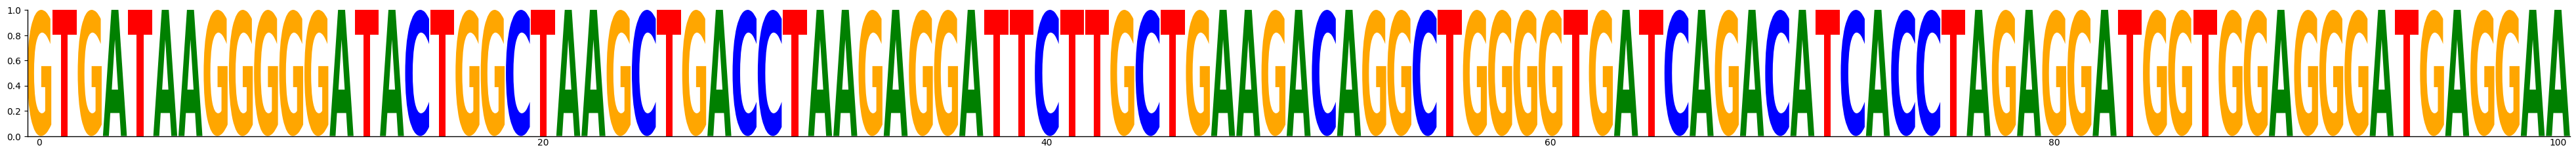

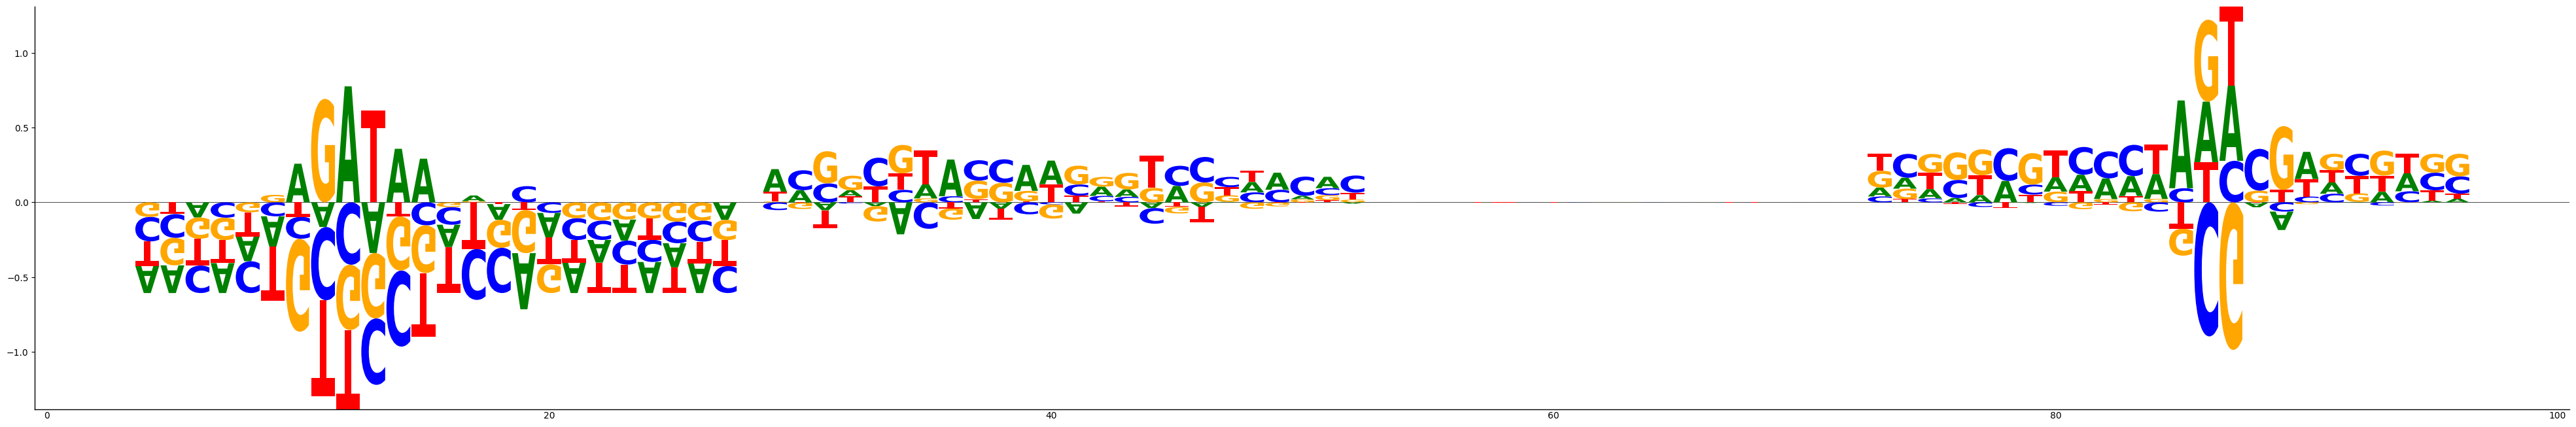

In [574]:
def create_logo(data, figsize, scale_data=False, visible_spines=None):
    if visible_spines is None:
        visible_spines = ["left", "bottom"]

    # Reshape and prepare the data
    output = {
        nucleotide: data[idx].reshape(data.shape[1]) for idx, nucleotide in enumerate("ACGT")
    }
    df = pd.DataFrame(output)

    # Optionally scale the data
    if scale_data:
        df /= df.max()

    # Create Logo object
    logo = logomaker.Logo(df, figsize=figsize)

    # Style the logo
    logo.style_spines(visible=False)
    logo.style_spines(spines=visible_spines, visible=True)
    logo.ax.set_ylabel("", labelpad=-1)
    logo.ax.xaxis.set_ticks_position("none")
    logo.ax.xaxis.set_tick_params(pad=-1)
    return logo


scale_data = False
# Create logos for each dataset
print("Original Sequence")
crp_df_original_logo = create_logo(original_image, figsize=[50, 2.5])
print("Vanilla Gradients")
crp_logo = create_logo(grads, figsize=[50, 8], scale_data=scale_data)
# print("Vanilla Gradients")
# vg_crp_logo = create_logo(vanilla_grads, figsize=[50, 8], scale_data=True)

ShiftSmoothed Gradients
ShiftSmoothed Gradients (Shifted 2)
ShiftSmoothed Gradients (Shifted 77)


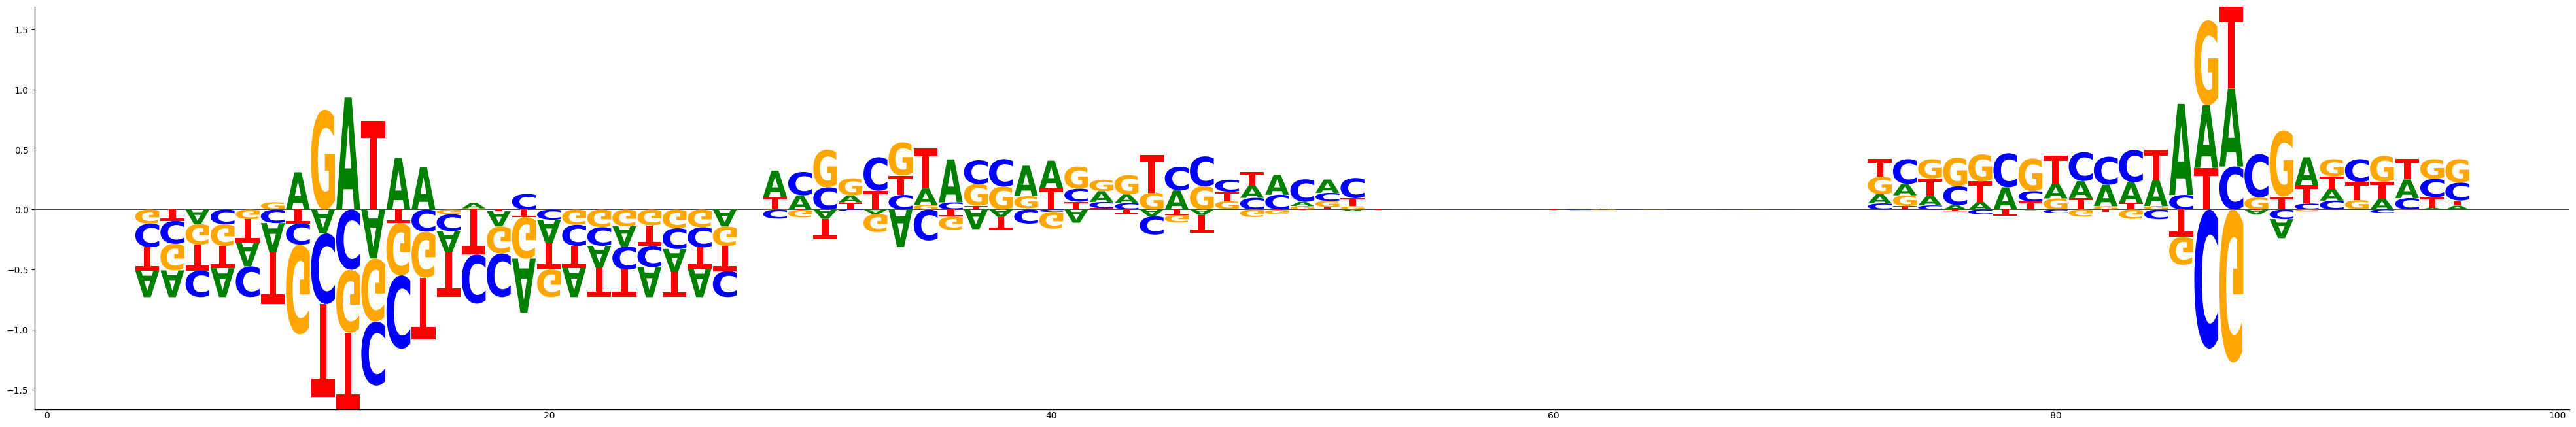

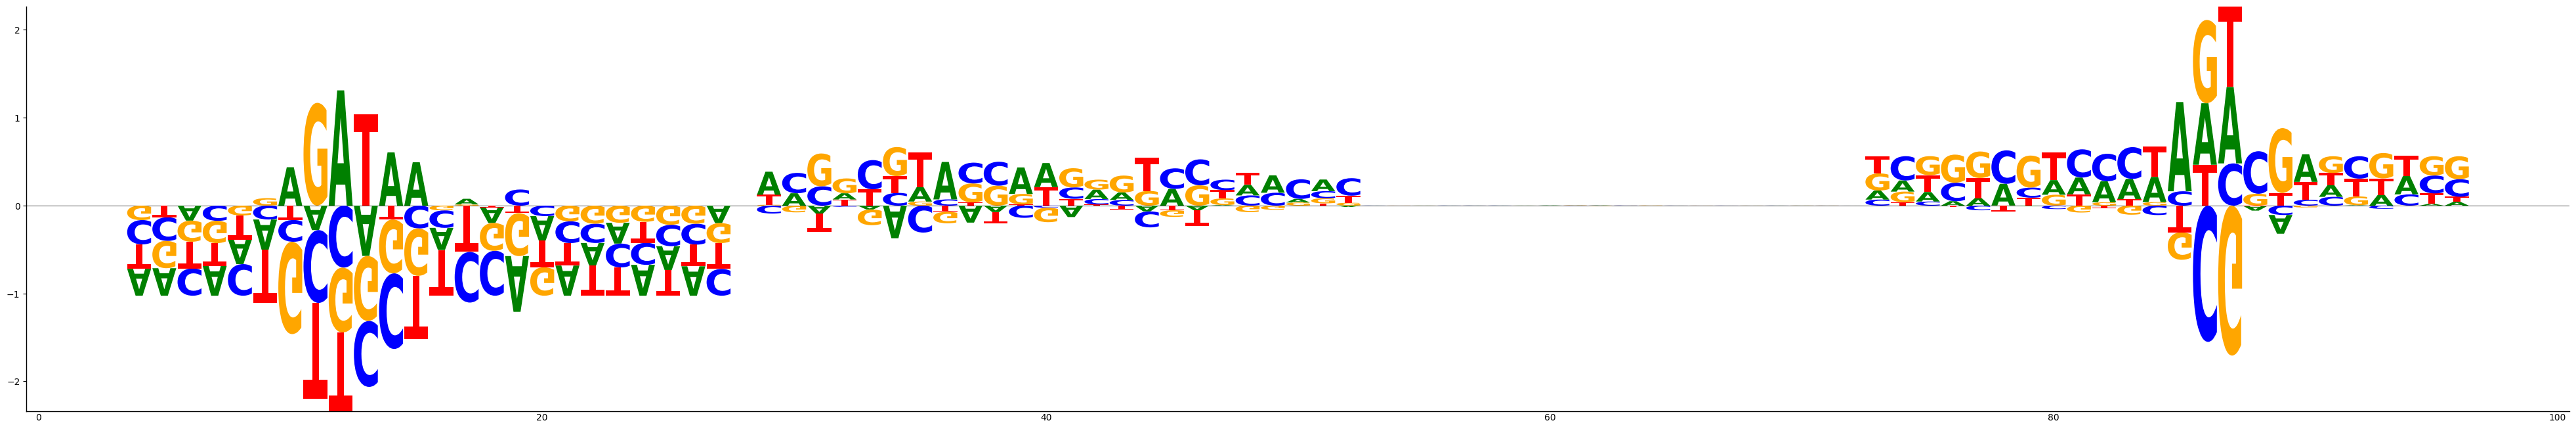

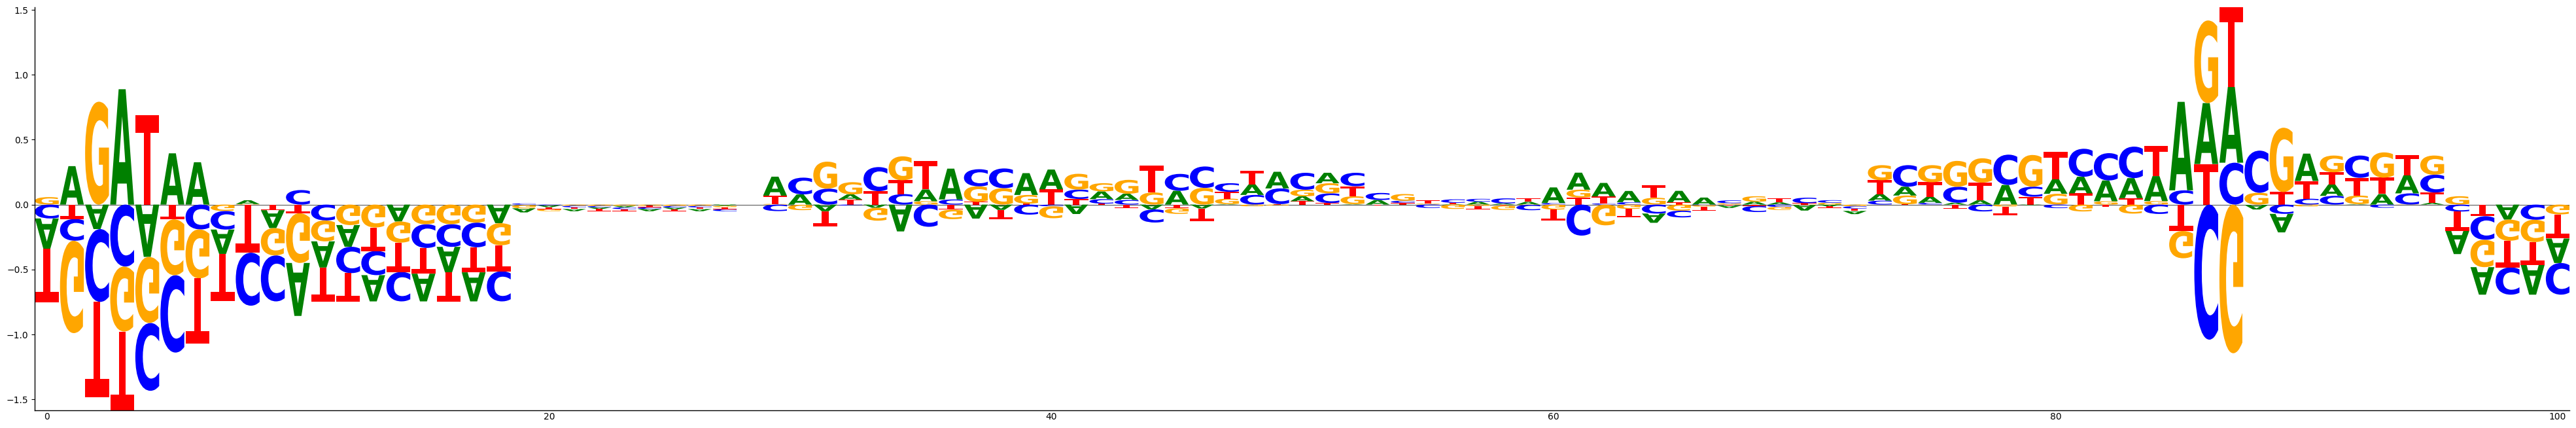

In [575]:
print("ShiftSmoothed Gradients")
shiftsmooth_crp_df_logo = create_logo(attr_shiftsmooth, figsize=[50, 8], scale_data=scale_data)
for attr_shiftsmooth2, i in attr_shiftsmooths:
    print(f"ShiftSmoothed Gradients (Shifted {i})")
    shiftsmooth_crp_df_logo = create_logo(attr_shiftsmooth2, figsize=[50, 8], scale_data=scale_data)



---

MoE Vanilla Gradients (Expert 0)
MoE Vanilla Gradients (Expert 1)
MoE Vanilla Gradients (Expert 2)


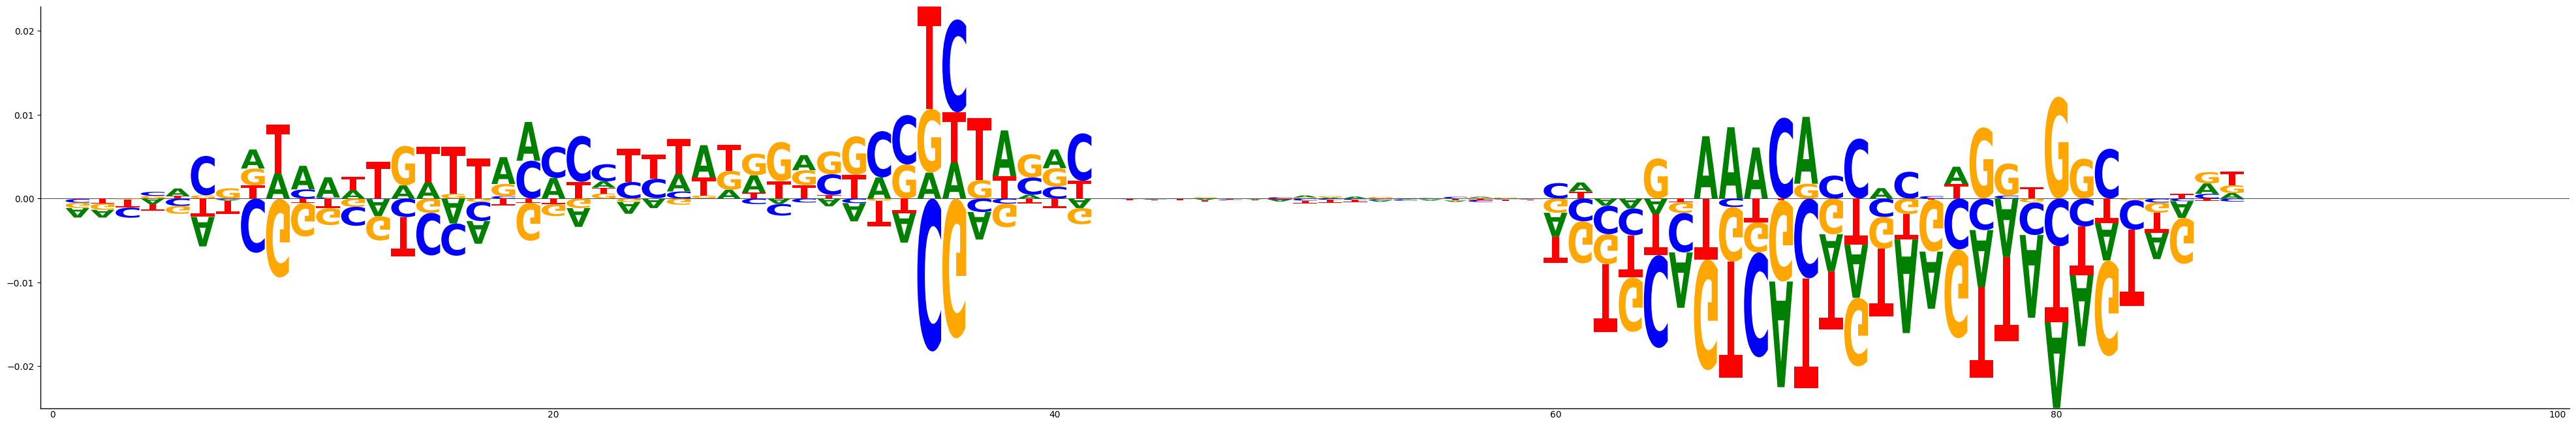

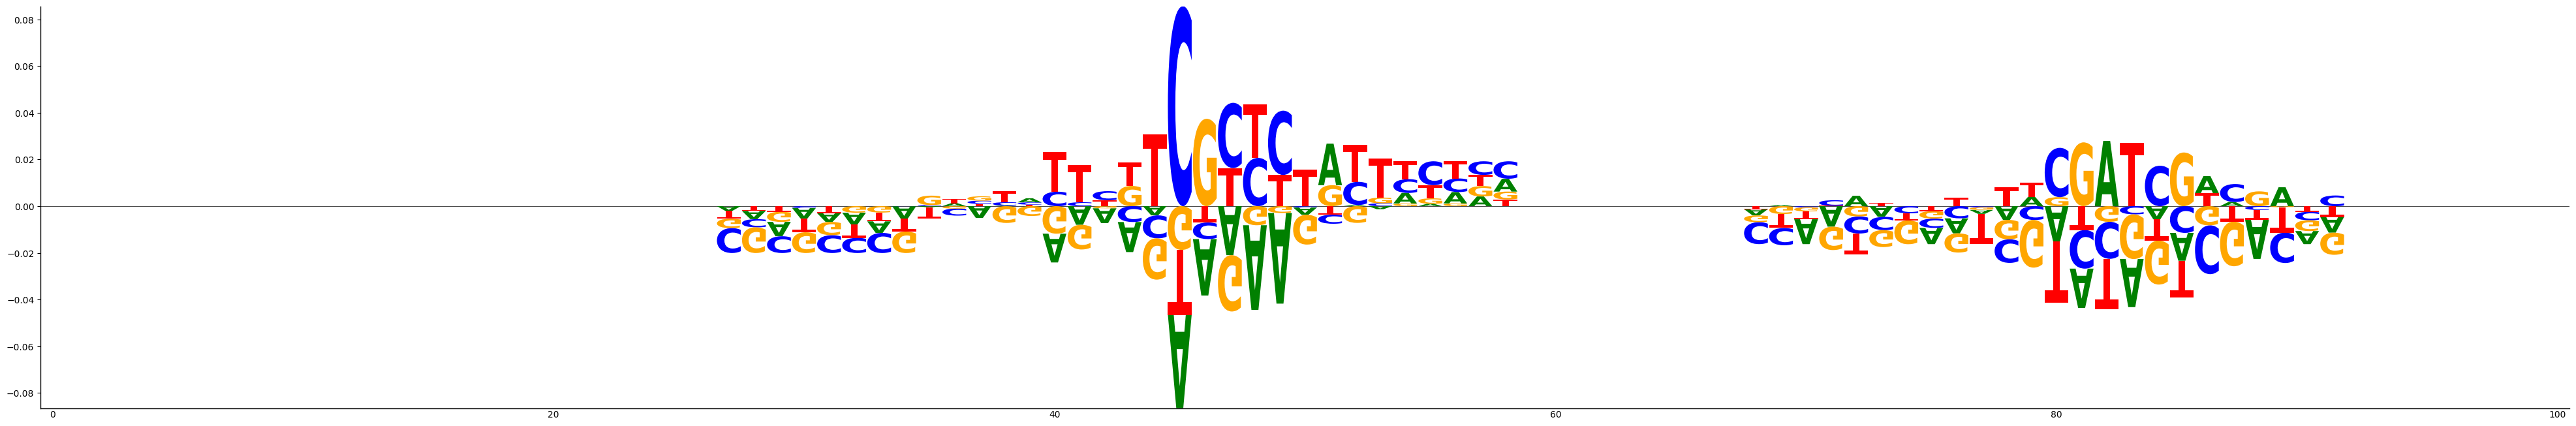

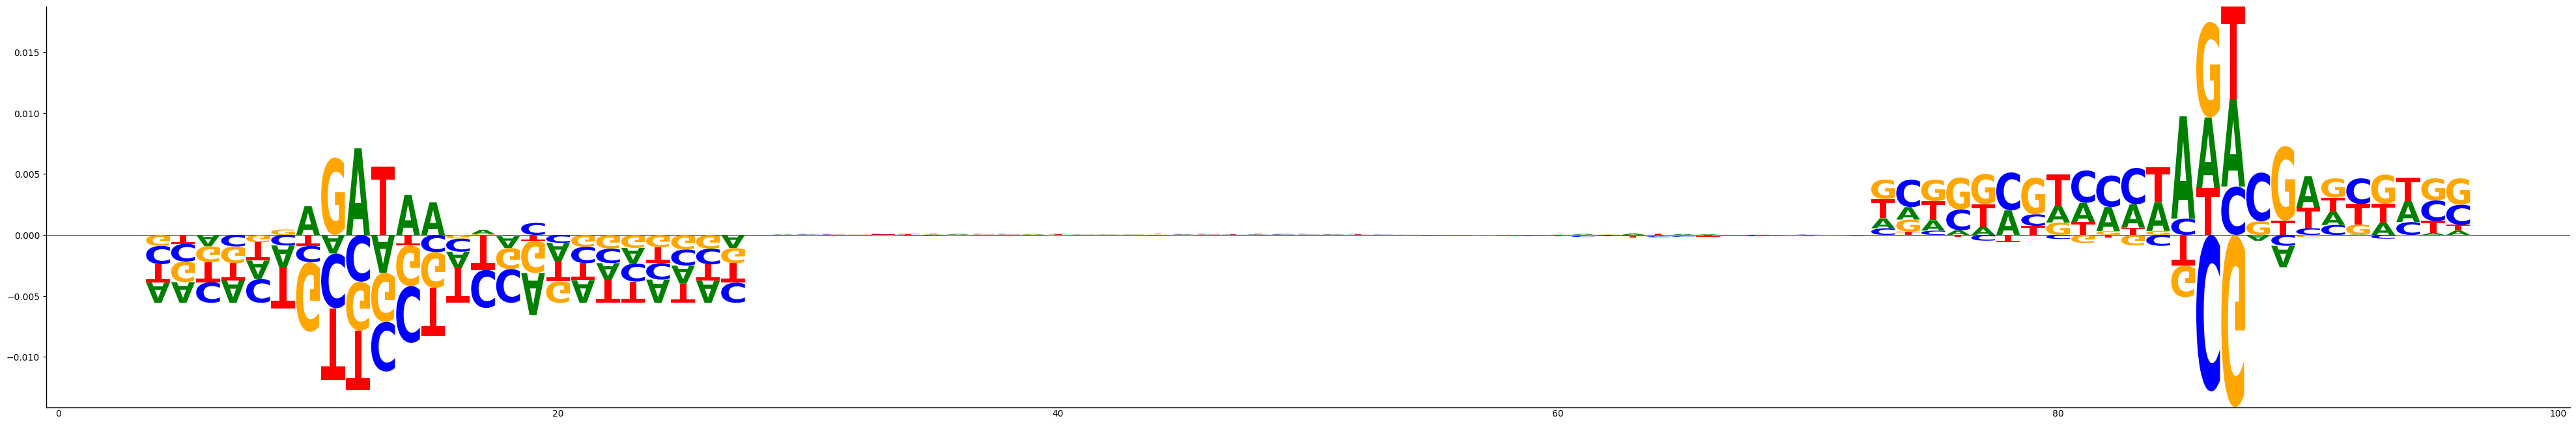

In [576]:

for i, moe_grad_ in enumerate(moe_grads_separate):
    print(f"MoE Vanilla Gradients (Expert {i})")
    moe_crp_df_logo = create_logo(moe_grad_, figsize=[50, 8], scale_data=scale_data)


MoE Vanilla Gradients


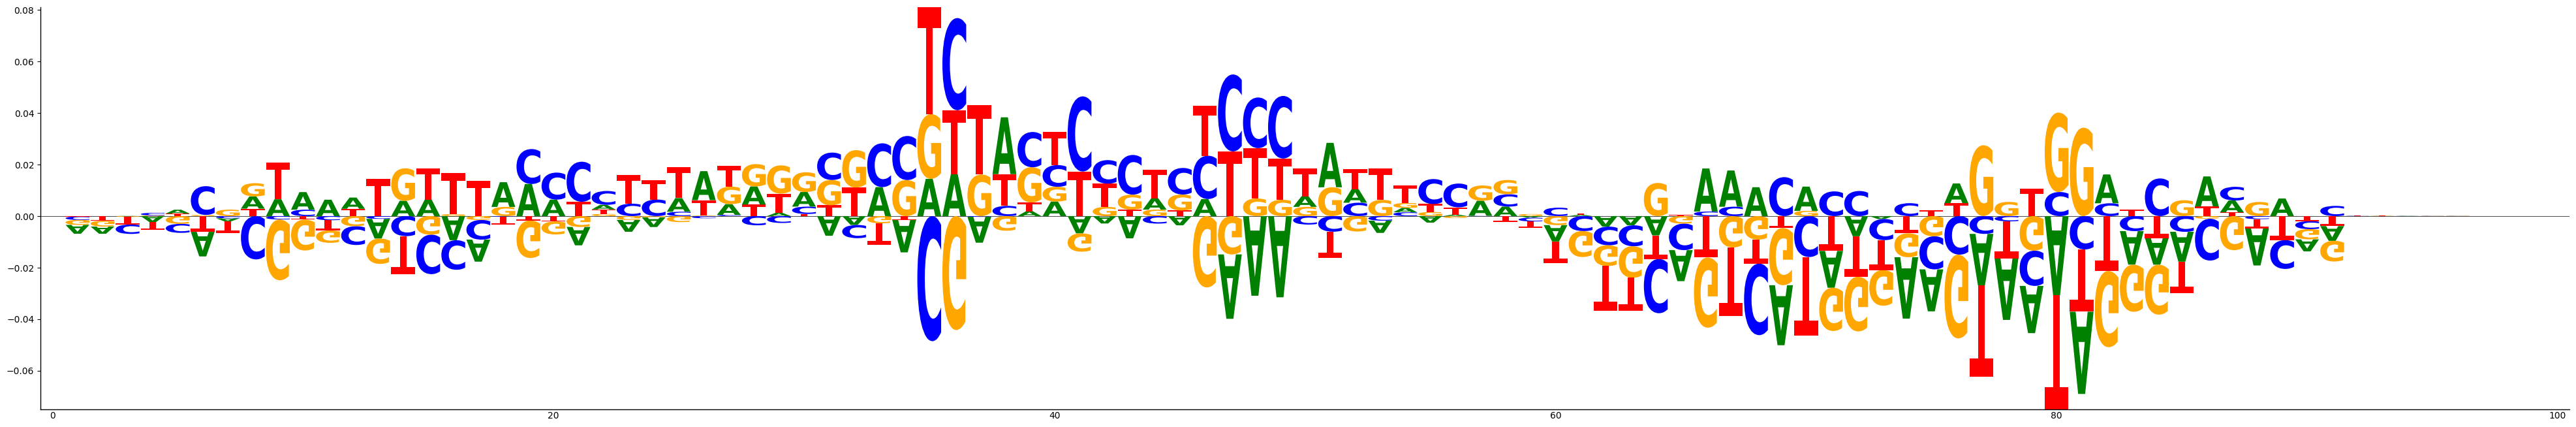

In [577]:
print("MoE Vanilla Gradients")
moe_crp_df_logo = create_logo(moe_grad, figsize=[50, 8], scale_data=scale_data)
# print("MoE 2 Vanilla Gradients")
# moe_crp_df_logo = create_logo(moe_grad_, figsize=[50, 8], scale_data=scale_data)


ShiftSmoothed Gradients (Shifted 2)
ShiftSmoothed Gradients (Shifted 77)


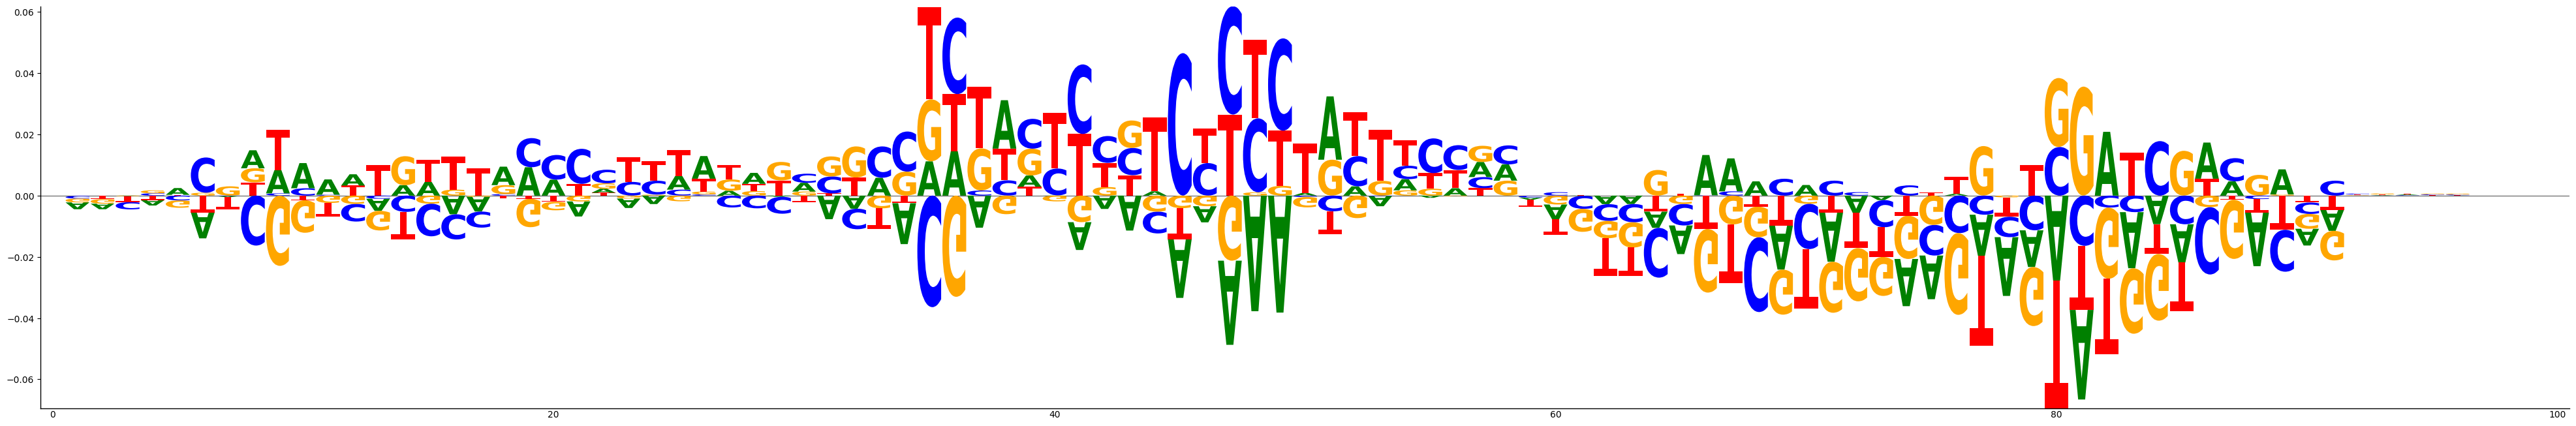

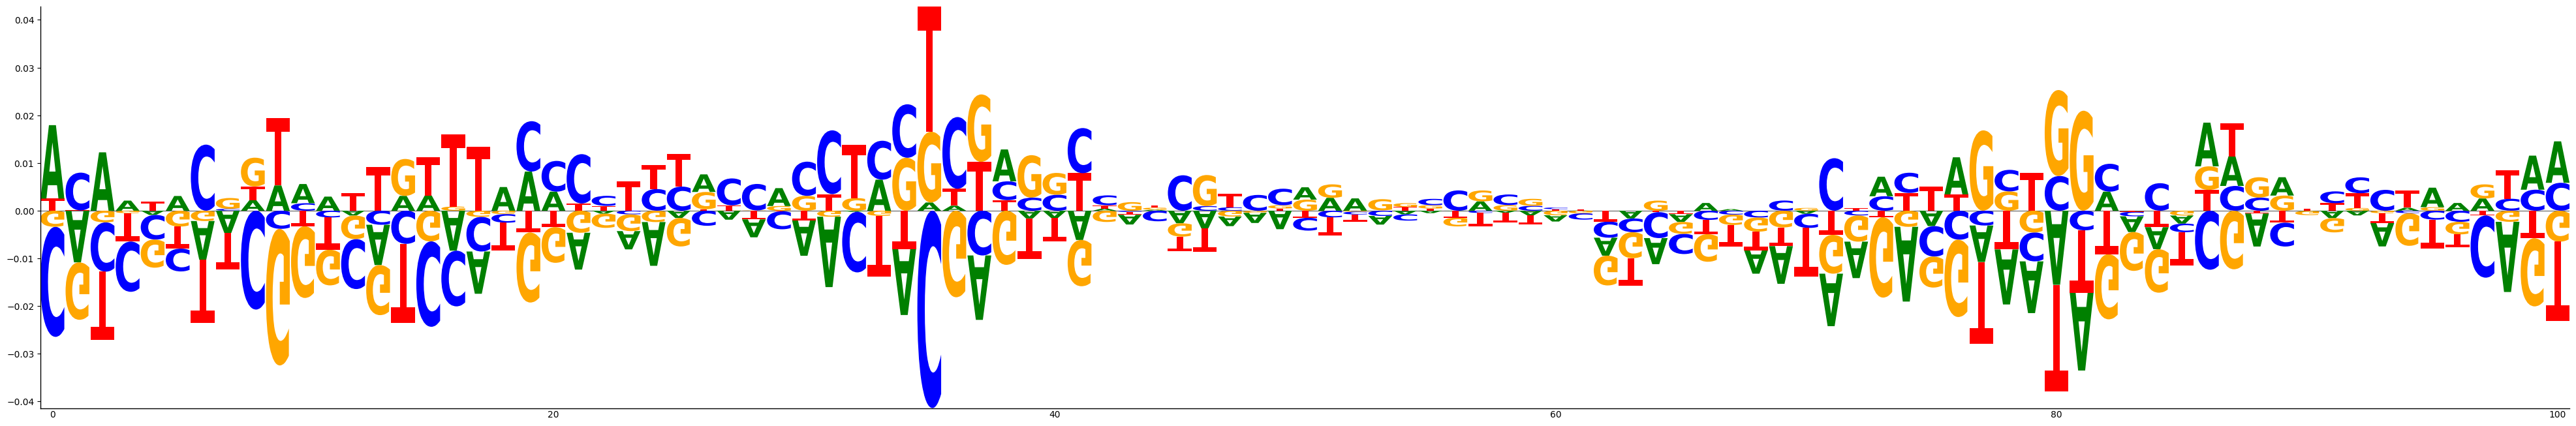

In [578]:
for moe_shiftsmooth, i in moe_shiftsmooths:
    print(f"ShiftSmoothed Gradients (Shifted {i})")
    shiftsmooth_moe_df_logo = create_logo(moe_shiftsmooth, figsize=[50, 8], scale_data=scale_data)

DeepLIFT


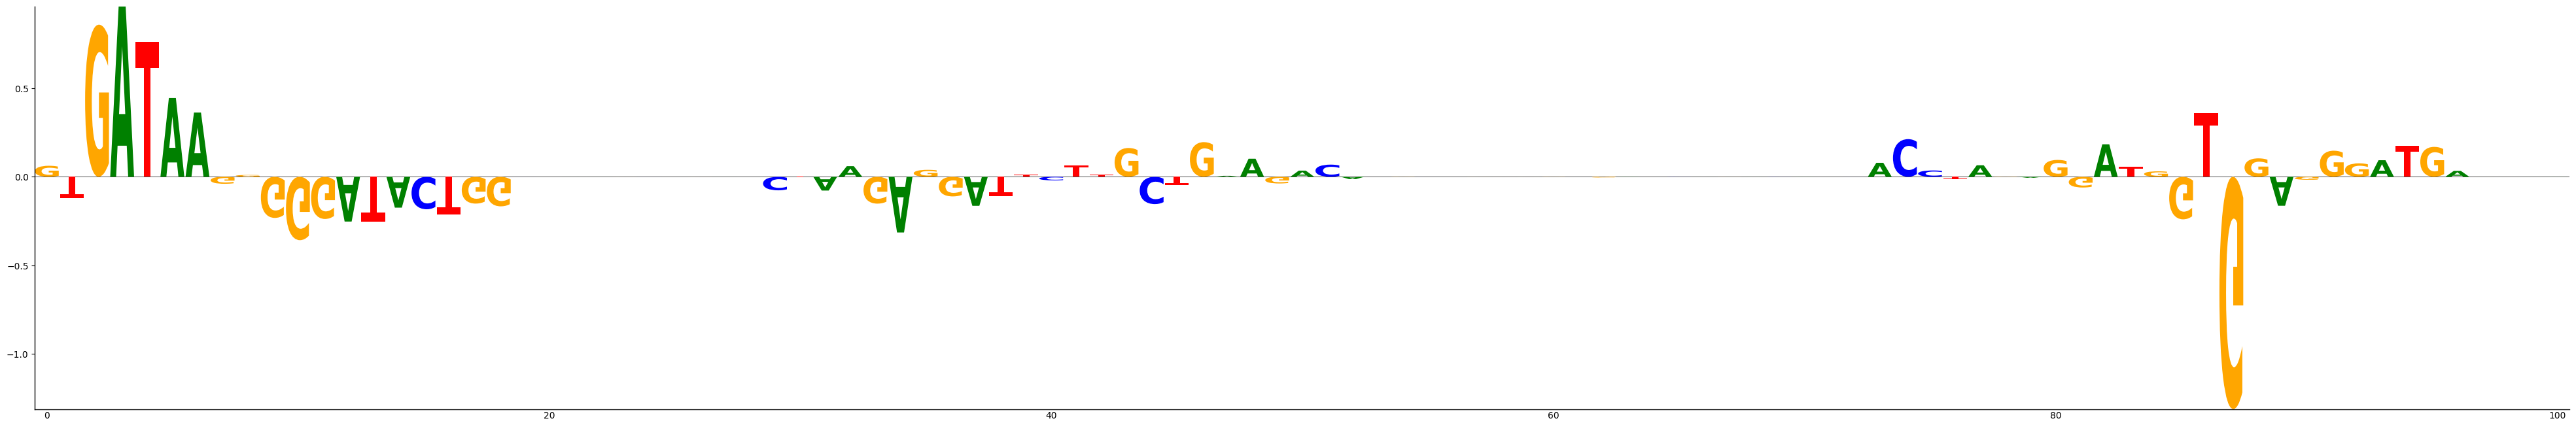

In [579]:
print("DeepLIFT")
dl_crp_df_logo = create_logo(attr_dl, figsize=[50, 8], scale_data=scale_data)

In [580]:
# import csv
# import gzip

# import logomaker
# import matplotlib.pyplot as plt
# import numpy as np
# import optuna
# import pandas as pd
# import torch
# import torch.nn as nn
# from captum.attr import Saliency
# from captum.attr import visualization as viz
# from torch.utils.data import DataLoader, Dataset

# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# class CNNEmbedding(nn.Module):
#     def __init__(self, embedding_dim, dropout_rate=0.5):
#         super(CNNEmbedding, self).__init__()
#         self.conv1 = nn.Conv1d(4, 32, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool1d(kernel_size=2)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
#         self.fc = nn.Linear(64 * 36, embedding_dim)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.dropout(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x


# # Define the transformer model
# class TransformerModel(nn.Module):
#     def __init__(
#         self,
#         embedding_dim,
#         dropout_rate=0.5,
#         dim_feedforward=512,
#         nhead=8,
#         num_encoder_layers=6,
#         num_decoder_layers=6,
#     ):
#         super(TransformerModel, self).__init__()
#         self.embedding = CNNEmbedding(embedding_dim, dropout_rate)
#         self.transformer = nn.Transformer(
#             nhead=nhead,
#             num_encoder_layers=num_encoder_layers,
#             num_decoder_layers=num_decoder_layers,
#             d_model=embedding_dim,
#             dim_feedforward=dim_feedforward,
#             batch_first=True,
#         )
#         self.fc = nn.Linear(embedding_dim, 1)

#     def forward(self, src):
#         src = self.embedding(src)
#         output = self.transformer(src, src)
#         output = self.fc(output)
#         return output


# class ChipDataLoader:
#     def __init__(self, filename, motiflen=24):
#         self.filename = filename
#         self.motiflen = motiflen

#     def seqtopad(self, sequence, kind="DNA"):
#         rows = len(sequence) + 2 * self.motiflen - 2
#         S = np.zeros([rows, 4], dtype=np.float32)
#         base = "ACGT" if kind == "DNA" else "ACGU"
#         for i in range(rows):
#             if i < self.motiflen - 1 or i >= len(sequence) + self.motiflen - 1:
#                 S[i] = 0.25
#             elif sequence[i - self.motiflen + 1] in base:
#                 S[i, base.index(sequence[i - self.motiflen + 1])] = 1
#         return S.T

#     def load_data(self):
#         data_set = []
#         with gzip.open(self.filename, "rt") as file:
#             next(file)  # Skip header if necessary
#             reader = csv.reader(file, delimiter="\t")
#             for row in reader:
#                 sequence = row[2]
#                 label = int(row[3])
#                 padded_sequence = self.seqtopad(sequence)
#                 data_set.append([padded_sequence, label])
#         return data_set


# class chipseq_dataset(Dataset):
#     def __init__(self, xy):
#         self.x_data = torch.tensor([el[0] for el in xy], dtype=torch.float32)
#         self.y_data = torch.tensor([el[1] for el in xy], dtype=torch.float32)
#         self.len = len(self.x_data)

#     def __getitem__(self, index):
#         return self.x_data[index], self.y_data[index]

#     def __len__(self):
#         return self.len


# chipseq_test = ChipDataLoader(
#     f"{data_path}/GATA1_K562_GATA-1_USC_B.seq.gz"
# )
# testdataset = chipseq_test.load_data()
# test_dataset = chipseq_dataset(testdataset)
# test_batch_size = test_dataset.len
# test_loader = DataLoader(
#     dataset=test_dataset, batch_size=test_batch_size, shuffle=False
# )
# study = optuna.load_study(
#     study_name="transformer",
#     storage="sqlite:///transformer.db",
# )
# model = TransformerModel(
#     embedding_dim=study.best_trial.params["embedding_dim"],
#     dropout_rate=study.best_trial.params["dropout_rate"],
#     num_encoder_layers=study.best_trial.params["num_encoder_layers"],
#     num_decoder_layers=study.best_trial.params["num_decoder_layers"],
# ).to(device)
# model.load_state_dict(torch.load("transformer.pth"))

# net = model.to(device)

# with torch.no_grad():
#     for i, (data, target) in enumerate(test_loader):
#         data = data.to(device)
#         target = target.to(device)

# original_image = np.transpose((data.cpu().detach().numpy()), (0, 1, 2))

# saliency = Saliency(net)
# grads = saliency.attribute(data)
# grads = grads.squeeze().cpu().detach().numpy()

# print(grads.shape, original_image.shape)
# # index = 4
# # index = np.random.randint(0, grads.shape[0])
# print(index)
# grads = grads[index]
# original_image = original_image[index]
# print(grads.shape, original_image.shape)
# grads = grads.reshape(4, 147, 1)
# original_image = original_image.reshape(4, 147, 1)
# print(grads.shape, original_image.shape)

# _ = viz.visualize_image_attr(
#     None, original_image, method="original_image", title="Original Sequence"
# )
# _ = viz.visualize_image_attr(
#     grads, original_image, method="heat_map", sign="all", title="Vanilla Gradients"
# )


# def create_logo(data, figsize, scale_data=False, visible_spines=None):
#     if visible_spines is None:
#         visible_spines = ["left", "bottom"]

#     # Reshape and prepare the data
#     output = {
#         nucleotide: data[idx].reshape(147) for idx, nucleotide in enumerate("ACGT")
#     }
#     df = pd.DataFrame(output)

#     # Optionally scale the data
#     if scale_data:
#         df /= df.max()

#     # Create Logo object
#     logo = logomaker.Logo(df, figsize=figsize)

#     # Style the logo
#     logo.style_spines(visible=False)
#     logo.style_spines(spines=visible_spines, visible=True)
#     logo.ax.set_ylabel("", labelpad=-1)
#     logo.ax.xaxis.set_ticks_position("none")
#     logo.ax.xaxis.set_tick_params(pad=-1)
#     return logo


# # Create logos for each dataset
# crp_df_original_logo = create_logo(original_image, figsize=[50, 2.5])
# crp_logo = create_logo(grads, figsize=[50, 8], scale_data=True)